In [3]:
import pandas as pd
import numpy as np

In [4]:
# Read the expected csv (the original data)

In [31]:
expected_df = pd.read_csv('/users/israelsofer/Data/new_model_category/expected.csv', error_bad_lines=False)

b'Skipping line 499: expected 8 fields, saw 9\nSkipping line 1319: expected 8 fields, saw 9\nSkipping line 3439: expected 8 fields, saw 10\nSkipping line 12263: expected 8 fields, saw 9\nSkipping line 22993: expected 8 fields, saw 9\nSkipping line 26163: expected 8 fields, saw 9\nSkipping line 26175: expected 8 fields, saw 11\nSkipping line 36298: expected 8 fields, saw 9\nSkipping line 36944: expected 8 fields, saw 9\nSkipping line 37769: expected 8 fields, saw 9\nSkipping line 39104: expected 8 fields, saw 10\nSkipping line 39835: expected 8 fields, saw 10\nSkipping line 40541: expected 8 fields, saw 10\nSkipping line 44991: expected 8 fields, saw 9\nSkipping line 45301: expected 8 fields, saw 9\nSkipping line 48692: expected 8 fields, saw 9\nSkipping line 57388: expected 8 fields, saw 9\nSkipping line 59540: expected 8 fields, saw 11\n'
b'Skipping line 66851: expected 8 fields, saw 9\nSkipping line 67602: expected 8 fields, saw 9\nSkipping line 72583: expected 8 fields, saw 9\nSkipp

In [32]:
expected_df.shape

(145305, 8)

In [33]:
expected_df.columns

Index(['bar_product_id', 'title', 'price', 'category_id', 'country_id',
       'pos_category_name', 'unique_id', 'train'],
      dtype='object')

In [34]:
expected_df.rename(columns={'category_id' : 'category_id_expected'}, inplace=True)

In [35]:
expected_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145305 entries, 0 to 145304
Data columns (total 8 columns):
bar_product_id          145305 non-null int64
title                   144555 non-null object
price                   145305 non-null float64
category_id_expected    145305 non-null int64
country_id              145305 non-null object
pos_category_name       118606 non-null object
unique_id               145305 non-null int64
train                   145305 non-null int64
dtypes: float64(1), int64(4), object(3)
memory usage: 8.9+ MB


In [36]:
actual_df = pd.read_csv('/users/israelsofer/Data/new_model_category/actual.csv', header=None)

In [37]:
actual_df.shape

(144788, 3)

In [38]:
actual_df.head(10)

0         1       2
0  5  0.988112  292486
1  6  0.997150  302881
2  5  0.432099  308710
3  5  0.989316  313680
4  4  0.995959  363174
5  5  0.525342  390098
6  5  0.874095  395074
7  1  0.999210  397115
8  5  0.968199  425620
9  4  0.529726  429637

In [39]:
# Show items with no prediction!!!! Error....
actual_df.columns = ['category_id_actual', 'category_id_prob', 'bar_product_id']

In [40]:
actual_df[actual_df['category_id_actual'].isnull()]

Empty DataFrame
Columns: [category_id_actual, category_id_prob, bar_product_id]
Index: []

In [41]:
actual_df = actual_df[actual_df['category_id_actual'].notnull()]

In [42]:
actual_df['category_id_prob'] = actual_df['category_id_prob'].apply(lambda prob: round(prob, 2))

In [43]:
total = actual_df.shape[0]
above_thesh = actual_df[actual_df['category_id_prob'] > 0.9].shape[0]
print('Items above theshold for category are: ', above_thesh, 'out of', total)

Items above theshold for category are:  122880 out of 144788


In [44]:
actual_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144788 entries, 0 to 144787
Data columns (total 3 columns):
category_id_actual    144788 non-null int64
category_id_prob      144788 non-null float64
bar_product_id        144788 non-null int64
dtypes: float64(1), int64(2)
memory usage: 4.4 MB


In [45]:
actual_df['category_id_actual'] = actual_df['category_id_actual'].astype('int')

In [46]:
joined_df = expected_df.merge(actual_df, on='bar_product_id')

In [47]:
joined_df.shape

(144546, 10)

In [49]:
joined_df.category_id_expected.unique()

array([5, 6, 4, 2, 1, 3])

In [50]:
joined_df.category_id_actual.unique()

array([5, 6, 4, 1, 2, 3])

In [51]:
joined_df.head(10)

bar_product_id               title  price  category_id_expected country_id  \
0          292486        MED SAIGNANT   0.00                     5     Canada   
1          302881     VERRE VIN BLANC   2.61                     6     Canada   
2          308710   MARIE-EVE LEPINAY   0.00                     5     Canada   
3          313680  CLIENT INSATISFAIT  15.00                     5     Canada   
4          363174              SPRITE   3.95                     4     Canada   
5          390098         BNI MATINAL   8.83                     2     Canada   
6          395074            POUR MOI   0.00                     5     Canada   
7          397115   PICHET BUD HOCKEY  10.00                     1     Canada   
8          425620           SANS FEVE   0.00                     5     Canada   
9          429637         ORANGE/KIWI   0.00                     5     Canada   

    pos_category_name  unique_id  train  category_id_actual  category_id_prob  
0                 NaN          5      0                   5              0.99  
1                 VIN          6      0                   6              1.00  
2                 NaN          5      0                   5              0.43  
3  CLIENT INSATISFAIT          5      0                   5              0.99  
4           breuvages          4      0                   4              1.00  
5           dejeuners          2      0                   5              0.53  
6                 NaN          5      0                   5              0.87  
7          biereenfut          1      0                   1              1.00  
8                 NaN          5      0                   5              0.97  
9                 NaN          5      0                   4              0.53

## Find the optimal threshold

In [92]:
report_df = joined_df
start = 0.5
threshold_list = []
matching_size_list = []
accuracy_list = []
for i in range(1,50):
    threshold = start + 0.01 * i
    y_true = report_df[report_df.category_id_prob > threshold].category_id_expected
    y_pred = report_df[report_df.category_id_prob > threshold].category_id_actual
    accuracy_list.append(accuracy_score(y_true, y_pred))
    matching_size = sum(report_df.category_id_prob > threshold)/report_df.shape[0]
    threshold_list.append(threshold)
    matching_size_list.append(matching_size)

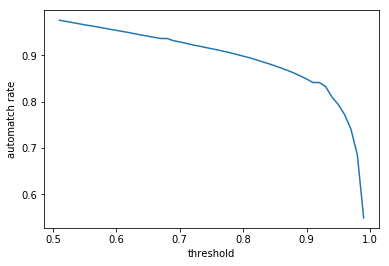

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(threshold_list, matching_size_list)
plt.xlabel('threshold')
plt.ylabel('automatch rate')
plt.show()

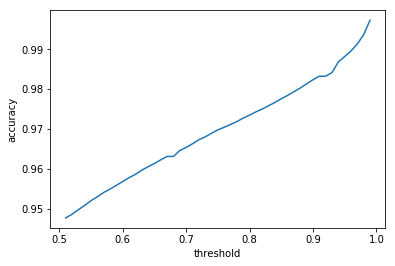

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(threshold_list, accuracy_list)
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.show()

In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(matching_size_list, accuracy_list)
plt.xlabel('aut-match size')
plt.ylabel('accuracy')
plt.show()

In [93]:
# Choose your theshold

In [94]:
from sklearn.metrics import accuracy_score, classification_report
top_df = joined_df[joined_df.category_id_prob > 0.8]
print(top_df.shape[0], 'out of', joined_df.shape[0], 'with coverage', top_df.shape[0]/joined_df.shape[0])
y_true = top_df.category_id_expected
y_pred = top_df.category_id_actual
print(accuracy_score(y_true, y_pred))

print(classification_report(y_true, y_pred))

129784 out of 144546 with coverage 0.8978733413584603
0.9734713061702521
             precision    recall  f1-score   support

          1       0.97      0.99      0.98     24013
          2       0.97      0.98      0.97     22646
          3       0.97      0.97      0.97     23331
          4       0.96      0.98      0.97     19658
          5       0.97      0.92      0.94     18456
          6       0.98      0.99      0.99     21680

avg / total       0.97      0.97      0.97    129784



# Write code to check the mistakes for the threshold chosen

In [67]:
# Mistakes with Category X
X = 3
joined_df[(joined_df.category_id_prob > 0.9) & ((joined_df.category_id_actual != X) & 
                                                (joined_df.category_id_expected == X))]

bar_product_id                                              title  \
84             1647678                                      Rib Eye 500gr   
366            5044834                                250ml Fly Zeb - Red   
517            6582064                                    PRIVATEER AMBER   
742             979734                                       VOIR SERVEUR   
1204           6001788                                    VIRGIN LONG ISL   
1244           6466279  Louis Bouillot, Brut Rosé, Crémant de Bourgogn...   
1528           1874020                                          STELLA.Mg   
1968           6207617                                      Lillet Blonde   
2765           7221716                                 happy black velvet   
3279           5105072                                   Hot Drink Refill   
3794           3017899                BrookVale Union Ginger Beer can 6pk   
3955           4194150                                                7UP   
4157           6200938                                          Negra Btl   
4164           6285421                                  Funaguchi (200ml)   
4498           2679564                                          open misc   
4765           5157748                                    Jif lemon juice   
4854           6081516                            DO NOT MAKE Archie Rose   
6196           4974858                                   J20 Apple & Rasp   
6723           3531482                                             MIMOSA   
6961           5275096                     CK 100ml Sour Worms On Ice 6mg   
7664           5225542                                    LG - TOM.B.PARM   
8339           4970415                                    Lemonade (half)   
8428           5671091                                 175ml Absurd Blanc   
8437           5791478                                      Post Mix Pint   
9269           6815955                               Gls Cow Bombie Chard   
9865           5289416                             Maxi Everyday Brew Tea   
10497          4368715                                      Macchiato Dbl   
10640          5920336                                       2 x coke can   
10996          2981366                                    Pitcher Mojitto   
11800          3122767                               Polarised Sunglasses   
...                ...                                                ...   
137887         7104929                                     Spanish Coffee   
137908         7309050                                     Shirley Temple   
138375         4324203                                         PS Gl Jeio   
138854         1733292                                   REK. SPICED PLUM   
139149         5096746                                 Coffee Delight x 1   
139495         1244042                                       BELAIRE ROSE   
139568         2292162                                        1L Red Sang   
139582         2685104                                     KIDS ORANGEADE   
139730         4075624                             Henry Weinhard - Grape   
140390         3779652                       Lazy Magnolia Southern Pecan   
140516         4778390                                        Spirit Misc   
140659         6168443                      Virgin Blood Orange Margarita   
140882          451786                                                KIR   
140944         1488809                                           Lg Pepsi   
140948         1530956                              Campo Tempranillo 6oz   
141268         5289552                             Classroom Bitter 1/2pt   
141424         7128298                                               Judy   
141449         7497139                                    Miller N Mezcal   
141626         1563780                                       Dinner Grill   
141661         1955321                                             DIVERS   
1423